In [1]:
import cv2, matplotlib.pyplot as plt
import numpy as np

In [4]:
def show(img, title='', size=6):
    plt.figure(figsize=(size, size))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

img1 = cv2.imread('opera1.JPG')
img2 = cv2.imread('opera2.JPG')

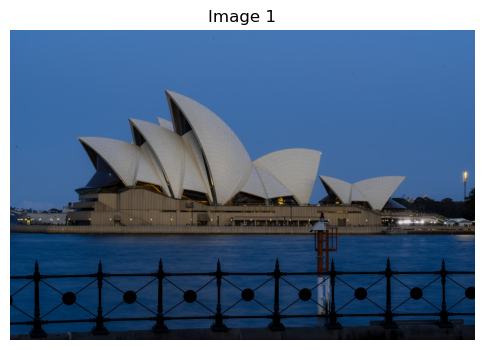

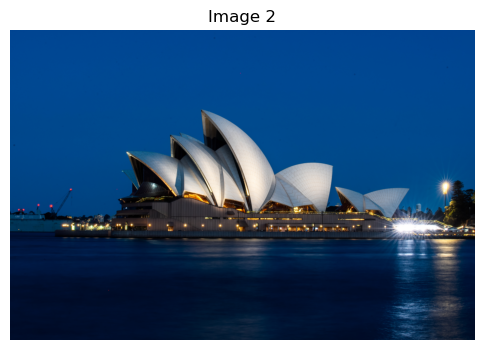

In [5]:
def resize_keep_ratio(img, width=1024):
    h, w = img.shape[:2]
    if w > width:
        scale = width / w
        return cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    return img

img1 = resize_keep_ratio(img1)
img2 = resize_keep_ratio(img2)

show(img1, 'Image 1')
show(img2, 'Image 2')

In [51]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print(f'Image 1 keypoint: {len(kp1)}')
print(f'Image 2 keypoint: {len(kp2)}')

Image 1 keypoint: 1171
Image 2 keypoint: 896


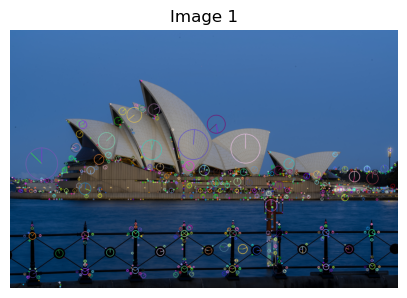

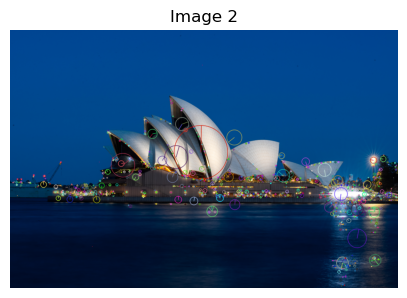

In [52]:
draw_params = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
img1_kp = cv2.drawKeypoints(img1, kp1, None, flags=draw_params)
img2_kp = cv2.drawKeypoints(img2, kp2, None, flags=draw_params)

show(img1_kp, 'Image 1')
show(img2_kp, 'Image 2')

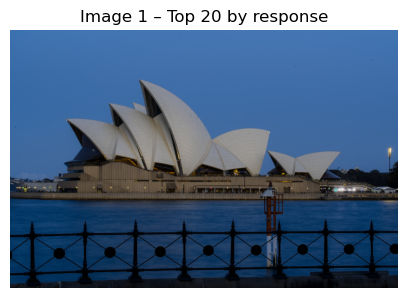

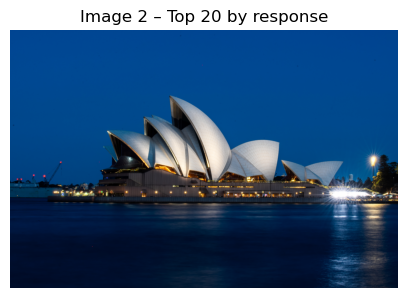

In [40]:
kp1_sorted = sorted(kp1, key=lambda x: -x.response)[:20]
kp2_sorted = sorted(kp2, key=lambda x: -x.response)[:20]

show(cv2.drawKeypoints(img1, kp1_sorted, None, flags=draw_params), 'Image 1 – Top 20 by response')
show(cv2.drawKeypoints(img2, kp2_sorted, None, flags=draw_params), 'Image 2 – Top 20 by response')

In this task, we choose detecting all SIFT keypoints with default parameters, the list is sorted by descending, keep 20 entries. Because this way is more stable, it is easy to compare in task 2.

In [41]:
import cv2, matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise

In [42]:
def show(img, title='', size=5):
    plt.figure(figsize=(size, size))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

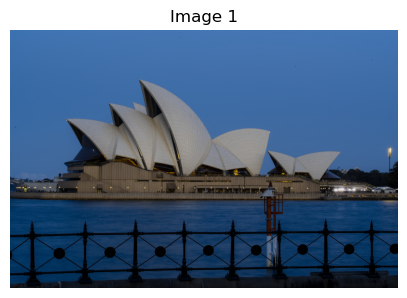

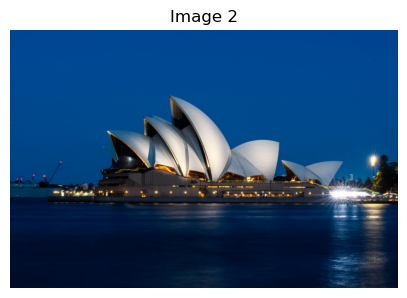

In [43]:
img1 = cv2.imread('opera1.JPG')
img2 = cv2.imread('opera2.JPG')

def resize_keep_ratio(img, width=1024):
    h, w = img.shape[:2]
    return cv2.resize(img, None, fx=width/w, fy=width/w, interpolation=cv2.INTER_AREA) if w > width else img

img1 = resize_keep_ratio(img1)
img2 = resize_keep_ratio(img2)

show(img1, 'Image 1')
show(img2, 'Image 2')

In [44]:
def img_transform(img, op):
    """op ∈ {'scale', 'rotate', 'noise'}"""
    if op == 'scale':
        return cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
    if op == 'rotate':
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), -60, 1)
        cos, sin = abs(M[0,0]), abs(M[0,1])
        new_w, new_h = int(h*sin + w*cos), int(h*cos + w*sin)
        M[0,2] += (new_w/2) - w/2
        M[1,2] += (new_h/2) - h/2
        return cv2.warpAffine(img, M, (new_w, new_h))
    if op == 'noise':
        noisy = (random_noise(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                              mode='s&p', amount=0.03) * 255).astype(np.uint8)
        return cv2.cvtColor(noisy, cv2.COLOR_RGB2BGR)
    return img.copy()

In [45]:
sift = cv2.SIFT_create()
draw_flag = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

def sift_top20(img):
    kp, des = sift.detectAndCompute(img, None)
    kp20 = sorted(kp, key=lambda k: -k.response)[:20]
    return kp20

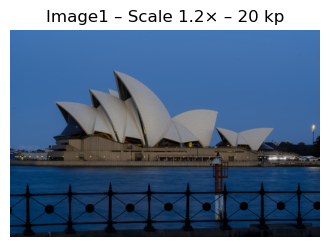

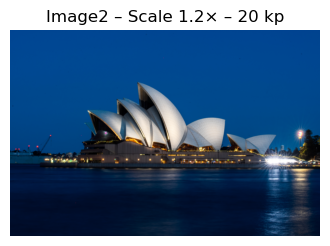

In [46]:
for tag, img in [('Image1', img1), ('Image2', img2)]:
    img_s = img_transform(img, 'scale')
    kp20 = sift_top20(img_s)
    show(cv2.drawKeypoints(img_s, kp20, None, flags=draw_flag),
         f'{tag} – Scale 1.2× – {len(kp20)} kp', size=4)

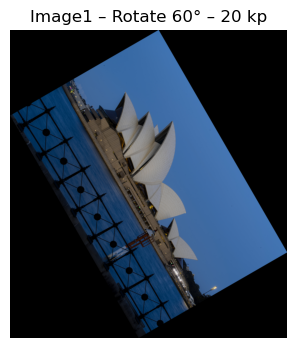

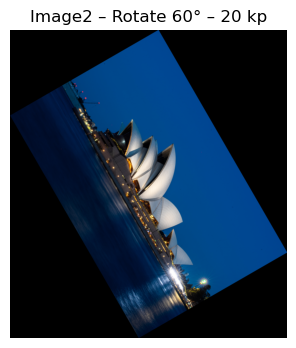

In [47]:
for tag, img in [('Image1', img1), ('Image2', img2)]:
    img_r = img_transform(img, 'rotate')
    kp20 = sift_top20(img_r)
    show(cv2.drawKeypoints(img_r, kp20, None, flags=draw_flag),
         f'{tag} – Rotate 60° – {len(kp20)} kp', size=4)

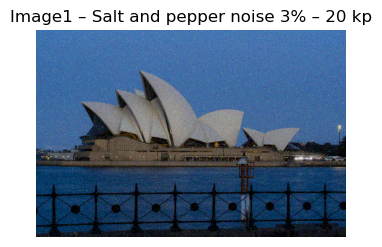

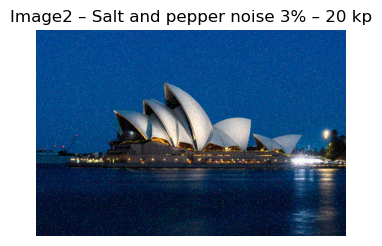

In [48]:
for tag, img in [('Image1', img1), ('Image2', img2)]:
    img_n = img_transform(img, 'noise')
    kp20 = sift_top20(img_n)
    show(cv2.drawKeypoints(img_n, kp20, None, flags=draw_flag),
         f'{tag} – Salt and pepper noise 3% – {len(kp20)} kp', size=4)

Scale 1.2× – After enlarging the picture a bit, SIFT still finds all 20 points in both photos. Size changes will not bother it.

Rotate +60° – Spin the image 60 degrees and SIFT keeps almost all of those points. Rotations also will not change a lot.

Salt and pepper noise 3 % – Add some speckly noise and a few points disappear, which can lower repeatability.

In [49]:
import cv2, numpy as np, matplotlib.pyplot as plt

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)
good = [m for m, n in matches if m.distance < 0.8 * n.distance]

print("Good matches:", len(good))
if len(good) < 4:
    raise ValueError("Less than 4 matches — cannot compute homography. "
                     "Try a larger ratio (e.g. 0.9) or different images.")

src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
print("Homography estimated.")

Good matches: 77
Homography estimated.


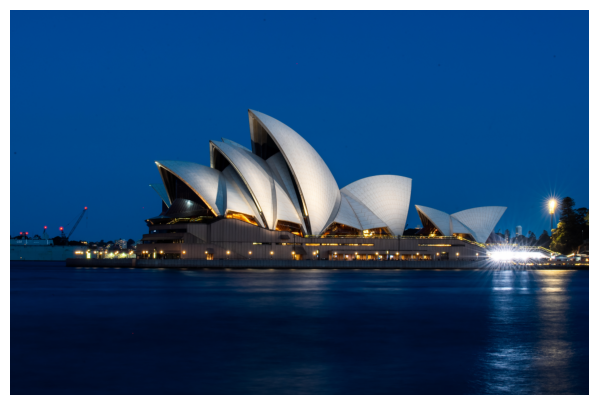

In [50]:
def stitch_two(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]]).reshape(-1, 1, 2)
    corners1_t = cv2.perspectiveTransform(corners1, H)
    corners2 = np.float32([[0, 0], [w2, 0], [w2, h2], [0, h2]]).reshape(-1, 1, 2)

    all_pts = np.concatenate((corners1_t, corners2), axis=0)
    xmin, ymin = np.int32(all_pts.min(axis=0).ravel() - 0.5)
    xmax, ymax = np.int32(all_pts.max(axis=0).ravel() + 0.5)

    tx, ty = -xmin, -ymin
    T = np.array([[1, 0, tx],
                  [0, 1, ty],
                  [0, 0, 1]])

    out_w, out_h = xmax - xmin, ymax - ymin

    panorama = cv2.warpPerspective(img1, T.dot(H), (out_w, out_h))
    panorama[ty:ty+h2, tx:tx+w2] = img2
    return panorama

result = stitch_two(img1, img2, H)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()